# Previsión de series temporales: Ventas

## Paso 1: Cargar el conjunto de datos

In [1]:
import pandas as pd

total_data = pd.read_csv("sales.csv")

total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.3
1,2022-09-04 17:10:08.079328,53.8
2,2022-09-05 17:10:08.079328,58.1
3,2022-09-06 17:10:08.079328,64.5
4,2022-09-07 17:10:08.079328,66.0


### Transformar cadena de fecha a objeto Datetime

In [2]:
total_data["date"] = pd.to_datetime(total_data.date)
total_data = total_data.set_index("date")
ts_total = total_data["sales"]
ts_total.head()

date
2022-09-03 17:10:08.079328   55.3
2022-09-04 17:10:08.079328   53.8
2022-09-05 17:10:08.079328   58.1
2022-09-06 17:10:08.079328   64.5
2022-09-07 17:10:08.079328   66.0
Name: sales, dtype: float64

### Trazar la serie temporal

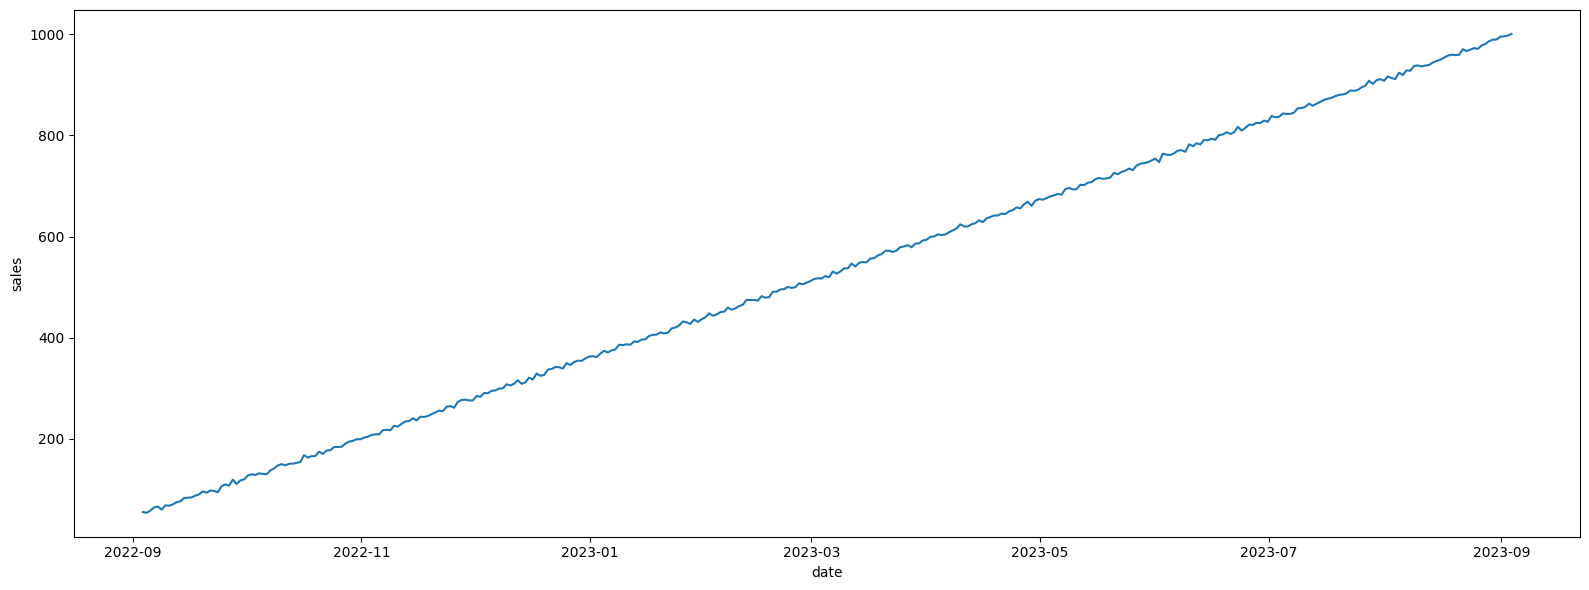

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (16, 6))

sns.lineplot(data = ts_total)

plt.tight_layout()

plt.show()

## Paso 2: Construir y analizar la serie temporal

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts_total)

Dickey-Fuller test results:


Test Statistic                  0.5
p-value                         1.0
#Lags Used                     13.0
Number of Observations Used   352.0
Critical Value (1%)            -3.4
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64

### Descomposición de la serie

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_total)
decomposition

### Análisis de tendencias

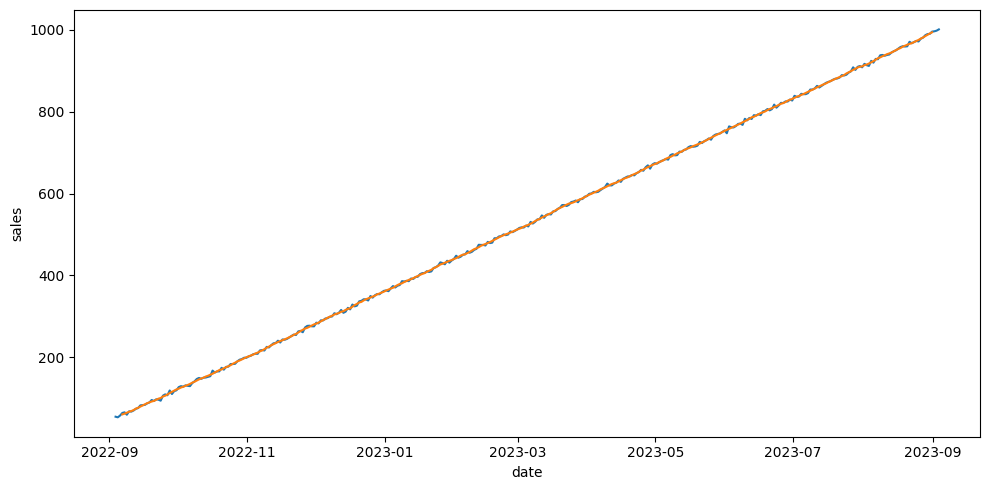

In [7]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Se aprecia una tendencia al alza en los datos

### Análisis de estacionalidad

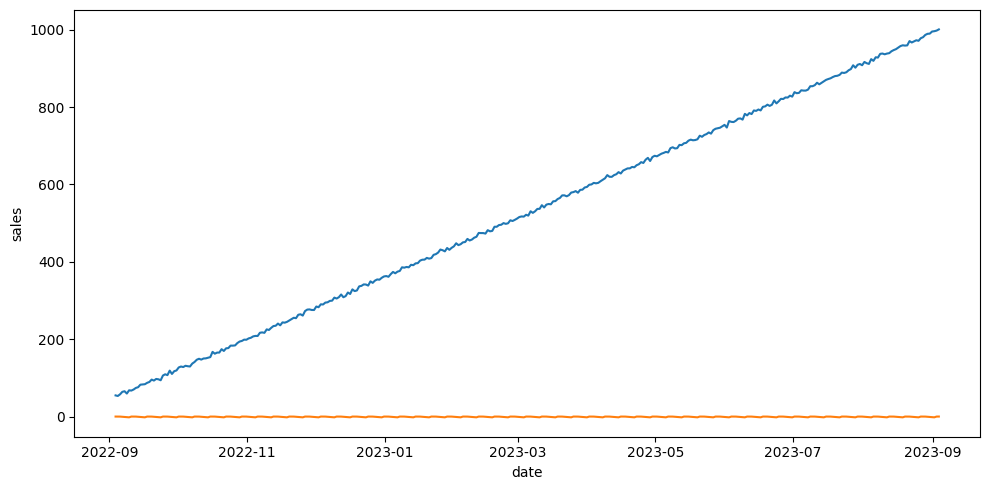

In [8]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionariedad de la serie temporal podemos aplicar el llamado **test de Dickey-Fuller**, que es un test de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa es que es no estacionaria:

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts_total)

Dickey-Fuller test results:


Test Statistic                  0.5
p-value                         1.0
#Lags Used                     13.0
Number of Observations Used   352.0
Critical Value (1%)            -3.4
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64

El valor `p` es superior a 0,05, por lo que la serie no es estacionaria. Trabajaremos con esta serie temporal sin transformarla.

### Análisis de variabilidad

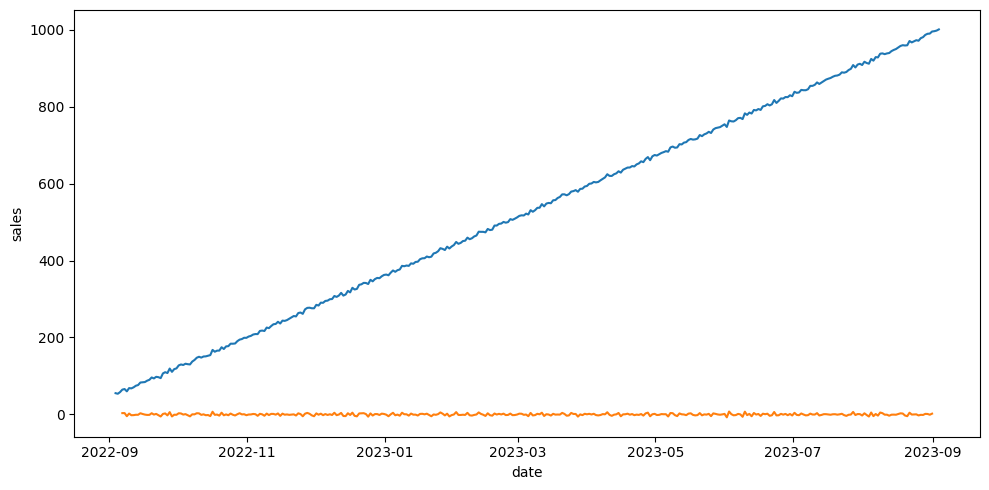

In [10]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

### Análisis de autocorrelación

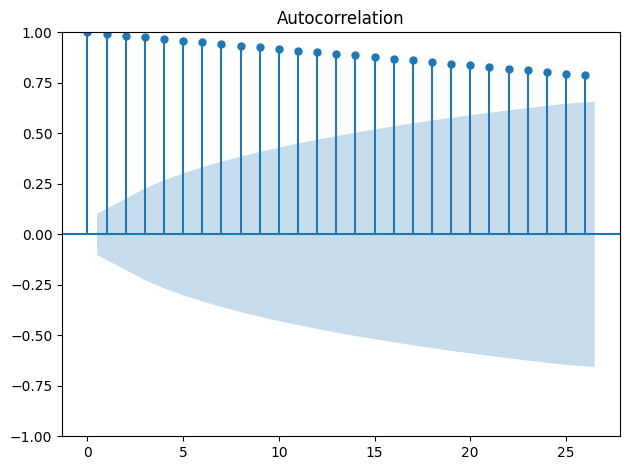

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_total)

plt.tight_layout()

plt.show()

A medida que avanzamos en la serie temporal, la autocorrelación se pierde regularmente, lo que dificulta la capacidad predictiva del modelo.

## Paso 3: Entrenar un ARIMA

In [12]:
from pmdarima import auto_arima

model = auto_arima(ts_total, seasonal = False, trace = True, m = 7)

/home/vscode/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.24 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.17 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.07 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.923 seconds


El mejor modelo ARIMA fue $ARIMA(1, 1, 1)$

## Paso 4: Predecir con el conjunto de prueba

El conjunto de prueba tiene 60 puntos, por lo que debe predecirse en 60 periodos futuros.

In [13]:
forecast = model.predict(60)
forecast

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-09-04 17:10:08.079328   1,002.2
2023-09-05 17:10:08.079328   1,004.8
2023-09-06 17:10:08.079328   1,007.4
2023-09-07 17:10:08.079328   1,010.0
2023-09-08 17:10:08.079328   1,012.6
2023-09-09 17:10:08.079328   1,015.2
2023-09-10 17:10:08.079328   1,017.8
2023-09-11 17:10:08.079328   1,020.4
2023-09-12 17:10:08.079328   1,023.0
2023-09-13 17:10:08.079328   1,025.6
2023-09-14 17:10:08.079328   1,028.2
2023-09-15 17:10:08.079328   1,030.8
2023-09-16 17:10:08.079328   1,033.4
2023-09-17 17:10:08.079328   1,036.0
2023-09-18 17:10:08.079328   1,038.6
2023-09-19 17:10:08.079328   1,041.2
2023-09-20 17:10:08.079328   1,043.8
2023-09-21 17:10:08.079328   1,046.4
2023-09-22 17:10:08.079328   1,049.0
2023-09-23 17:10:08.079328   1,051.6
2023-09-24 17:10:08.079328   1,054.2
2023-09-25 17:10:08.079328   1,056.8
2023-09-26 17:10:08.079328   1,059.4
2023-09-27 17:10:08.079328   1,062.0
2023-09-28 17:10:08.079328   1,064.6
2023-09-29 17:10:08.079328   1,067.2
2023-09-30 17:10:08.079328   1,069.8
2

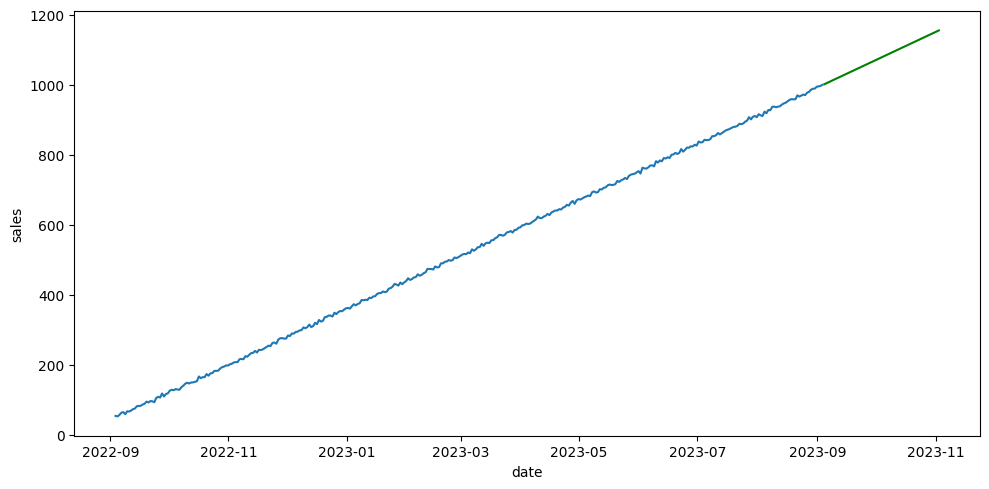

In [14]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()